## 1. About the Project

### 1.1 Rationale

Facial keypoints detection is a widely researched topic and an important foundation for various important applications including but not limited to:
1. Facial expression analysis
2. Medical diagnosis
3. Facial recognition
4. Fraud detection
5. Sentiment analysis

Hence, while developing an effective model is a very challenging problem given the sizable variety of possible faces, it can provide immense value in numerous different areas, from medicine to finance to social media. With the present COVID situation arround the world there might be an increasing need for facial keypoints detection in the avoidance of physical contact.

### 1.2 Objective

Given a 96 x 96 greyscale input image of a human face, the objective of the project is to accurately locate 15 facial keypoints. The output is an array of 30 elements containing the (x,y) coordinates of the 15 keypoints. 
We would like to build a model that not only achieves minimal loss on the training data but also generalizes well to new faces, since the ultimate goal is to achieve strong model performance on data we have never seen before.  

In [1]:
import functools, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization

Using TensorFlow backend.


# 2. Data Preprocessing
The dataset, including training and testing samples, is provided by Kaggle’s facial keypoints detection challenge. There are 7,049 images in total, each
of which is a 96 × 96 pixels image. Among the images, only 2,140 have all 15 ground truth facial keypoints defined.

In [15]:
training_data = 'training/training.csv'
test_data = 'test/test.csv'
lookup_data = 'lookup_data/IdLookupTable.csv'

In [18]:
# Load Training data
train_df = pd.read_csv(training_data) 
lookup_df= pd.read_csv(lookup_data) 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

Text(0.5, 1.0, 'Percent missing data by feature')

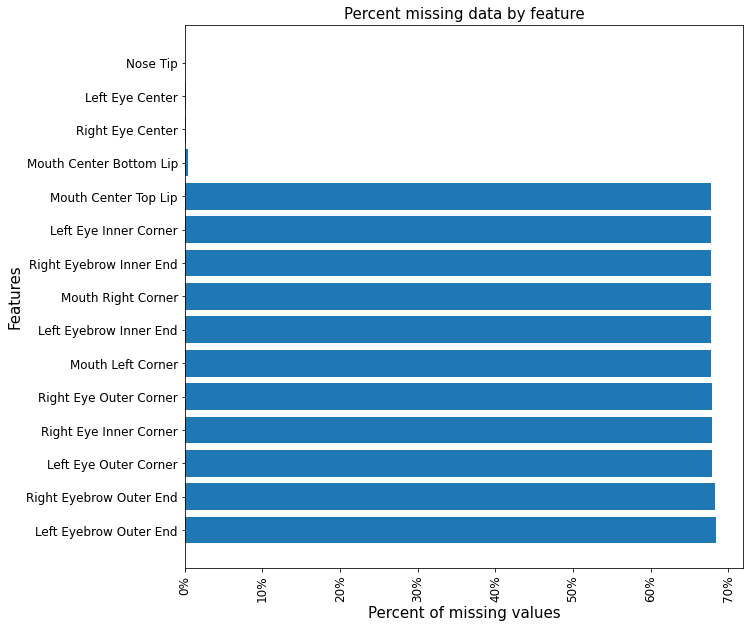

In [5]:
# Plot histogram for missing data
df=train_df[train_df.columns[:-1]]
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[['_x' in i for i in missing_data.index]] # remove repeated label

f, ax = plt.subplots(figsize=(10, 10))
plt.xticks(rotation='90')
point_labels = [i.replace('_x', '').replace('_', ' ').title() for i in missing_data.index]
plt.barh(point_labels, missing_data['Percent'])
plt.yticks(fontsize=12)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

As shown above, left_eye, right_eye, nose_tip and mouse_center_bottom_lip features are available for almost all images, but other keypoints are only available for 2,140 images.

In [6]:
# Obtain arrays of image input and keypoint output from train data
images = []
for i in range(0, len(train_df['Image'])):
    image = train_df['Image'][i].split(' ')
    images.append(image)
images = np.array(images, dtype = 'float')
keypoints = train_df[train_df.columns[:-1]].values

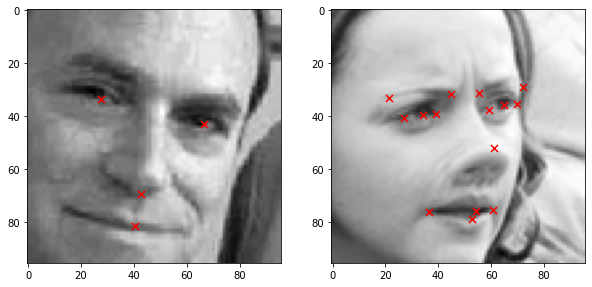

In [7]:
# Plot two sample images
fig,ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.reshape(images[5304],(96,96)),cmap='gray')
ax[0].scatter(keypoints[5304][0::2],keypoints[5304][1::2],marker="x",c='r',s=50 )
ax[1].imshow(np.reshape(images[1830],(96,96)),cmap='gray')
ax[1].scatter(keypoints[1830][0::2],keypoints[1830][1::2],marker="x",c='r',s=50 )
plt.show()

Above are two examples of sample images from the training set. On the left is an image with all 15 keypoints defined, and on the right is an image with only 4 keypoints.

### 2.4 Data loading and cleaning

In [8]:
#Load data from training , test csv
def loadData(test = False):
    # Initialize dataset based on train or test
    data = training_data
    if test:
        data = test_data
        
    df = pd.read_csv(data)
    df_datapoints = df[df.columns[:-1]]
    
    
    # Convert space-seperated image pixel values to numpy array of arrays
    images = []
    for i in range(0, len(df['Image'])):
        image = df['Image'][i].split(' ')
        images.append(image)
    
    # Scale pixels to between 0 and 1
    images = np.array(images, dtype = 'float') / 255
    
    # Reshape images to 96 x 96
    images = images.reshape(-1,96,96,1)
    
    keypoints=None
    
    if not test:
        # Fill NA values, with specific adjustments for special cases
        keypoints = df[df.columns[:-1]].copy()

        #1731, 1747, 1877, 1881, 1979, 2154, 2289, 2321, 2453, 3173, 3296, 3447, 4180, 5556, 6585, 6859 are images without mouths
        #These points will be filled with X=48, y=94 (middle bottom of image)
        for j in [1731, 1747, 1877, 1881, 1979, 2154, 2289, 2321, 2453, 3173, 3296, 3447, 4180, 5556, 6585, 6859]:
            keypoints.loc[j,"mouth_center_top_lip_x"]=48
            keypoints.loc[j,"mouth_center_top_lip_y"]=94
            
            keypoints.loc[j,"mouth_center_bottom_lip_x"]=48
            keypoints.loc[j,"mouth_center_bottom_lip_y"]=94

            keypoints.loc[j,"mouth_right_corner_x"]=33
            keypoints.loc[j,"mouth_right_corner_y"]=94

            keypoints.loc[j,"mouth_right_corner_x"]=63
            keypoints.loc[j,"mouth_right_corner_y"]=94
            
        # Replace remaining NAs with average value for each keypoint
        for name in keypoints.columns:
            keypoints[name].fillna(keypoints[name].mean(),inplace=True)
            
        # Normalize keypoints to between -1 and 1
        keypoints = ((keypoints.values - 48) / 48).astype(np.float)
        
        
    return images, keypoints


The function above returns the processed images for training and testing data. It also returns the keypoints in the case of testing. Pixel values are normalized to [0,1], and keypoints ara normalized to [-1, 1] and na-filled. 

In [9]:
# Load train and test data, print min and max pixel and coordinate values
training_images, training_keypoints = loadData()
testing_images, _ = loadData(test = True)
print("Training image pixel values - min: {:.3f}; max: {:.3f}".format(
    training_images.min(), training_images.max()))
print("Training keypoint coordinate values - min: {:.3f}; max: {:.3f}".format(
    training_keypoints.min(), training_keypoints.max()))

Training image pixel values - min: 0.000; max: 1.000
Training keypoint coordinate values - min: -0.986; max: 0.999


### 2.5 Plotting images

In [10]:
# Show a sample image with its keypoints
def show_sample_with_keypoints(image, keypoints, axis):
    axis.imshow(image.reshape(96, 96), cmap='gray')
    axis.scatter(keypoints[0::2] * 48 + 48, keypoints[1::2] * 48 + 48, marker='x', c='red', s = 50)
    
# Plot images and 15 coordinates on the image
def plot_sample_images(images, keypoints, num_rows, num_col):
    np.random.seed(72)
    random_index = np.random.randint(0, len(images), num_rows * num_col)
    fig, ax = plt.subplots(num_rows, num_col, figsize = (20,10))

    row = 0
    col = 0
    for i in random_index:
        show_sample_with_keypoints(images[i], keypoints[i], ax[row][col])
        col += 1
        if col == num_col:
            col = 0
            row += 1
            
    plt.tight_layout()
    plt.show()

These functions show sample images with their facial keypoints marked on the image. They allow us to easily analyze the dataset and validate our predictions. Below are some examples from the training set.

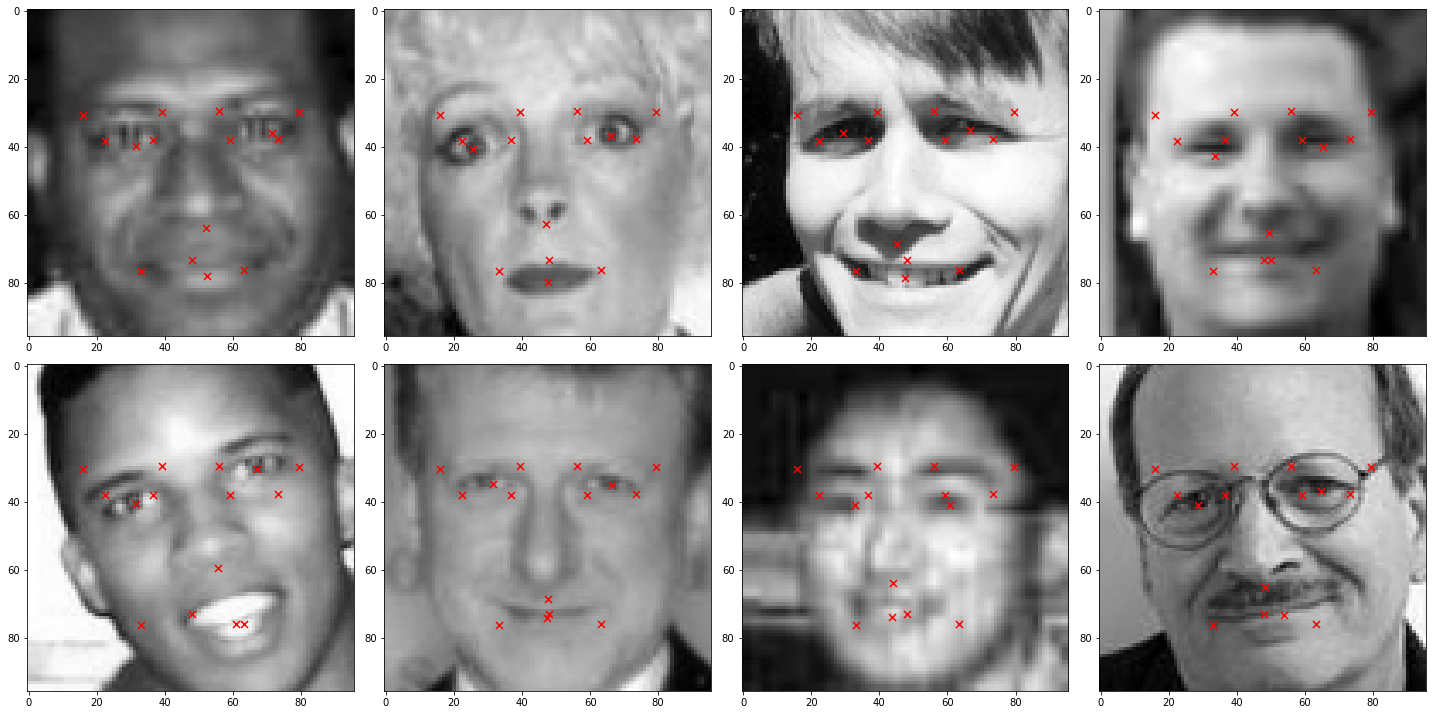

In [11]:
# Plot 8 sample images from train set
plot_sample_images(training_images, training_keypoints, 2, 4)

### 2.6 Plotting Loss

In [12]:
# Plot model loss for training and validation
def plot_loss(model, prefix=""):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
   
    plt.plot(loss,"--",linewidth=3,label= prefix + "Training")
    plt.plot(val_loss,linewidth=3,label=prefix + "Validation")

This function plots the training and validation losses on one graph and can help us evaluate performance

## 3.Models & Baseline selection

### 3.1 Single layer Neural Net

In [13]:
# Single layer neural network
def model_single():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(100))# number of units in hidden layer
    model.add(Activation('relu'))
    model.add(Dense(30))# 30 target values
      
    sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)
    model.compile(loss = 'mean_squared_error', optimizer = sgd,metrics = ['accuracy','mae'])
    return model 

We fit the single layer network over 100 epochs. Given that this is only our baseline model, we expect that there will be room for improvement in performance with the addition of convolutional layers and tuning of hyperparameters. Also, since we are limited in terms of computational time, we will run the model over 100 epochs.

#### Training

In [53]:
single_model = model_single()
single_fit = single_model.fit(training_images, training_keypoints, epochs = 100, validation_split = 0.2)

Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 1s 230us/step - loss: 0.0463 - accuracy: 0.4107 - mae: 0.1306 - val_loss: 0.0104 - val_accuracy: 0.2830 - val_mae: 0.0783
Epoch 2/100
5639/5639 [==============================] - 1s 195us/step - loss: 0.0080 - accuracy: 0.5086 - mae: 0.0645 - val_loss: 0.0089 - val_accuracy: 0.5092 - val_mae: 0.0688
Epoch 3/100
5639/5639 [==============================] - 1s 200us/step - loss: 0.0070 - accuracy: 0.5437 - mae: 0.0599 - val_loss: 0.0118 - val_accuracy: 0.4723 - val_mae: 0.0875
Epoch 4/100
5639/5639 [==============================] - 1s 194us/step - loss: 0.0063 - accuracy: 0.5602 - mae: 0.0559 - val_loss: 0.0055 - val_accuracy: 0.5340 - val_mae: 0.0545
Epoch 5/100
5639/5639 [==============================] - 1s 200us/step - loss: 0.0059 - accuracy: 0.5620 - mae: 0.0536 - val_loss: 0.0047 - val_accuracy: 0.5681 - val_mae: 0.0485
Epoch 6/100
5639/5639 [==============================] - 

5639/5639 [==============================] - 1s 208us/step - loss: 0.0032 - accuracy: 0.6714 - mae: 0.0345 - val_loss: 0.0023 - val_accuracy: 0.6149 - val_mae: 0.0293
Epoch 47/100
5639/5639 [==============================] - 1s 209us/step - loss: 0.0032 - accuracy: 0.6737 - mae: 0.0345 - val_loss: 0.0022 - val_accuracy: 0.6128 - val_mae: 0.0278
Epoch 48/100
5639/5639 [==============================] - 1s 223us/step - loss: 0.0032 - accuracy: 0.6718 - mae: 0.0345 - val_loss: 0.0021 - val_accuracy: 0.6099 - val_mae: 0.0262
Epoch 49/100
5639/5639 [==============================] - 1s 201us/step - loss: 0.0031 - accuracy: 0.6796 - mae: 0.0341 - val_loss: 0.0046 - val_accuracy: 0.5660 - val_mae: 0.0497
Epoch 50/100
5639/5639 [==============================] - 1s 198us/step - loss: 0.0031 - accuracy: 0.6753 - mae: 0.0342 - val_loss: 0.0021 - val_accuracy: 0.6064 - val_mae: 0.0261
Epoch 51/100
5639/5639 [==============================] - 1s 202us/step - loss: 0.0031 - accuracy: 0.6792 - mae: 

5639/5639 [==============================] - 1s 204us/step - loss: 0.0029 - accuracy: 0.7101 - mae: 0.0326 - val_loss: 0.0019 - val_accuracy: 0.6241 - val_mae: 0.0243
Epoch 92/100
5639/5639 [==============================] - 1s 209us/step - loss: 0.0029 - accuracy: 0.7152 - mae: 0.0325 - val_loss: 0.0021 - val_accuracy: 0.6199 - val_mae: 0.0261
Epoch 93/100
5639/5639 [==============================] - 1s 205us/step - loss: 0.0029 - accuracy: 0.7145 - mae: 0.0326 - val_loss: 0.0019 - val_accuracy: 0.6170 - val_mae: 0.0243
Epoch 94/100
5639/5639 [==============================] - 1s 205us/step - loss: 0.0029 - accuracy: 0.7189 - mae: 0.0325 - val_loss: 0.0022 - val_accuracy: 0.5915 - val_mae: 0.0268
Epoch 95/100
5639/5639 [==============================] - 1s 207us/step - loss: 0.0029 - accuracy: 0.7141 - mae: 0.0325 - val_loss: 0.0019 - val_accuracy: 0.6071 - val_mae: 0.0249
Epoch 96/100
5639/5639 [==============================] - 1s 205us/step - loss: 0.0028 - accuracy: 0.7141 - mae: 

#### Predictions on Test Images

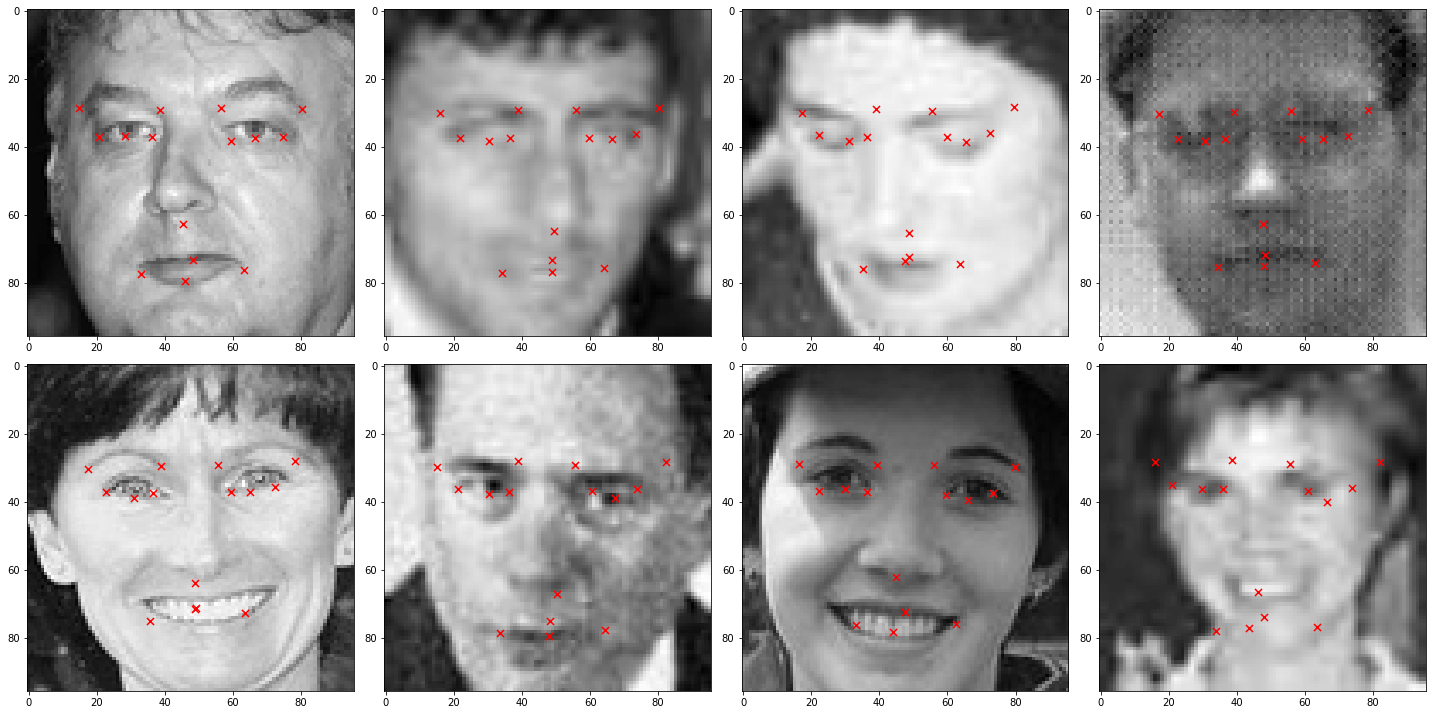

In [54]:
# Plot predicted keypoints on images from test set
single_pred = single_model.predict(testing_images)
plot_sample_images(testing_images, single_pred, 2, 4)

Overall, the model performs well on the test dataset. As expected, the more pixelated the images are, the less accurate the model is able to predict keypoints. The keypoints that suffer most seem to be eyebrows and mouth corners. 

#### Results

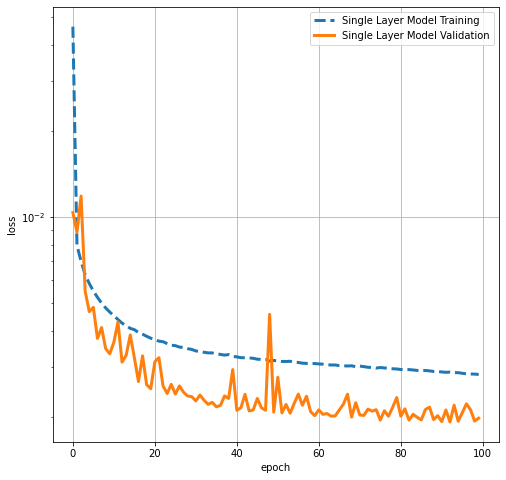

In [55]:
# Plot loss and validation loss for single layer NN
plt.figure(figsize=(8,8))
plot_loss(single_fit,"Single Layer Model ")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In this chart, we show how the model improved over each epoch. After around 40 epochs, the model is able to lower the level of loss from roughly 0.01 to 0.003, a considerable improvement. After that point, the improvement in performance with each epoch begins to decline, and performance starts to level off. 

### 3.2 Convolutional Neural Network

In [141]:
# Setting up the CNN
def model_CNN(withDropout = False, withBatchNormalization = False):
    model = Sequential([Dropout(0.1)])
    model.add(Conv2D(32,(3, 3), input_shape = (96, 96, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    if withBatchNormalization:
        model.add(BatchNormalization())
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    if withBatchNormalization:
        model.add(BatchNormalization())
        
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withBatchNormalization:
        model.add(BatchNormalization())
    
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    
    model.add(Dense(300))
    model.add(Activation('relu'))

    model.add(Dense(30))
    return(model)

##### Training with batch size of 32

In order to determine the optimal batch size, we train the baseline model with varying batch sizes to compare performance.

In [99]:
# Initialize CNN and SGD optimizer
baseline_32 = model_CNN()
sgd = SGD(lr = 0.01, momentum = 0.9, decay = 1e-6, nesterov = True)
baseline_32.compile(loss = "mean_squared_error", optimizer = sgd, metrics = ['mae'])

In [100]:
# Trains model with batch size 32
baseline_fit_32 = baseline_32.fit(training_images, training_keypoints, epochs = 100, validation_split = 0.2, batch_size = 32)

Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 4s 794us/step - loss: 0.0172 - mae: 0.0830 - val_loss: 0.0085 - val_mae: 0.0751
Epoch 2/100
5639/5639 [==============================] - 4s 753us/step - loss: 0.0045 - mae: 0.0433 - val_loss: 0.0067 - val_mae: 0.0667
Epoch 3/100
5639/5639 [==============================] - 4s 757us/step - loss: 0.0039 - mae: 0.0371 - val_loss: 0.0061 - val_mae: 0.0627
Epoch 4/100
5639/5639 [==============================] - 4s 770us/step - loss: 0.0038 - mae: 0.0349 - val_loss: 0.0059 - val_mae: 0.0612
Epoch 5/100
5639/5639 [==============================] - 4s 771us/step - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0055 - val_mae: 0.0586
Epoch 6/100
5639/5639 [==============================] - 4s 763us/step - loss: 0.0037 - mae: 0.0340 - val_loss: 0.0054 - val_mae: 0.0578
Epoch 7/100
5639/5639 [==============================] - 4s 751us/step - loss: 0.0037 - mae: 0.0338 - val_loss: 0.0059 - val_mae: 

Epoch 60/100
5639/5639 [==============================] - 4s 749us/step - loss: 0.0032 - mae: 0.0332 - val_loss: 0.0030 - val_mae: 0.0377
Epoch 61/100
5639/5639 [==============================] - 4s 757us/step - loss: 0.0032 - mae: 0.0332 - val_loss: 0.0029 - val_mae: 0.0370
Epoch 62/100
5639/5639 [==============================] - 4s 756us/step - loss: 0.0032 - mae: 0.0331 - val_loss: 0.0031 - val_mae: 0.0382
Epoch 63/100
5639/5639 [==============================] - 4s 765us/step - loss: 0.0032 - mae: 0.0332 - val_loss: 0.0029 - val_mae: 0.0372
Epoch 64/100
5639/5639 [==============================] - 4s 754us/step - loss: 0.0032 - mae: 0.0331 - val_loss: 0.0029 - val_mae: 0.0361
Epoch 65/100
5639/5639 [==============================] - 4s 750us/step - loss: 0.0032 - mae: 0.0331 - val_loss: 0.0031 - val_mae: 0.0379
Epoch 66/100
5639/5639 [==============================] - 4s 754us/step - loss: 0.0032 - mae: 0.0331 - val_loss: 0.0029 - val_mae: 0.0359
Epoch 67/100
5639/5639 [==========

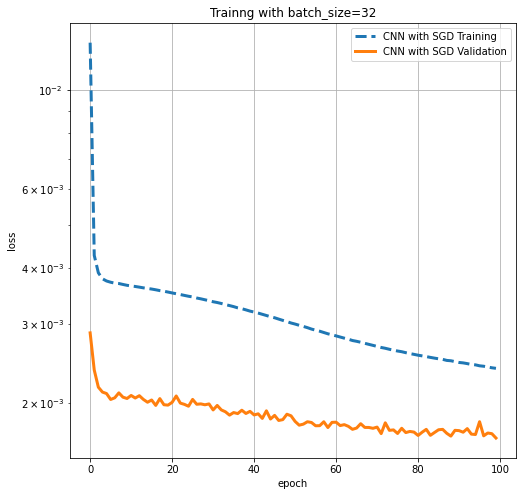

In [59]:
# Plot training and validation loss for baseline
plt.figure(figsize =(8, 8))
plot_loss(baseline_fit_32,"CNN with SGD ")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Trainng with batch_size=32")
plt.show()

This CNN model substantially improves upon the performance of the baseline model in that training and validation loss has decreased substantially. However, the training and validation performance of the model tends to move together across epochs, which again suggests that there is room to increase the complexity of the model without overfitting. With a batch size of 32, the model moves towards its performance limit quickly in the first few epochs, and then slowly thereafter. Increasing batch size speeds up training up but worsens the model's generalizability.

##### Predicting with CNN model trained with SGD optimizer and batch size 32

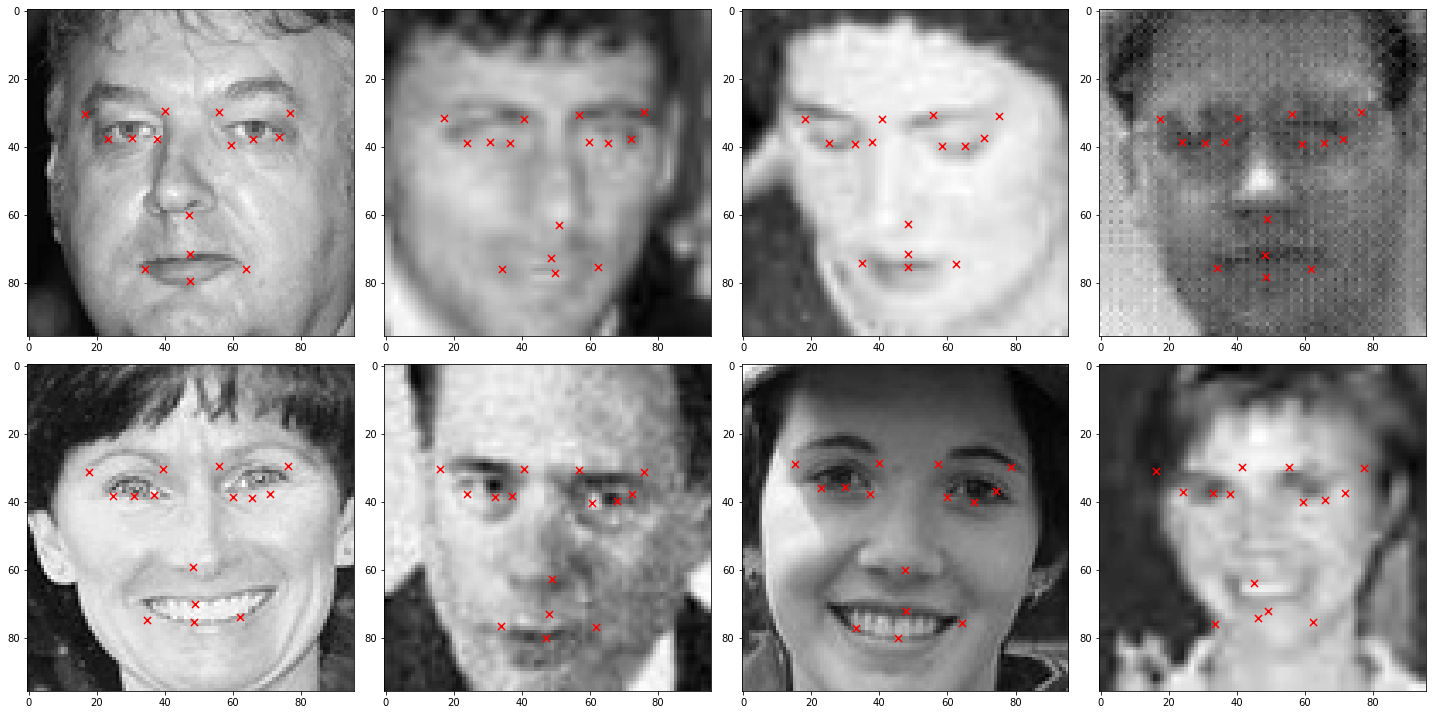

In [101]:
# Predict on testing images
baseline_pred = baseline_32.predict(testing_images)
plot_sample_images(testing_images, baseline_pred, 2, 4)

Same as the single layer, the model struggles with especially pixelated images. Visually there isn’t much distinction between this model and the single layer model. The largest distinction can be seen in top/bottom lip keypoints. The Baseline CNN is more capable of separating these keypoints in prediction.

#### 4.1.2 Training with Adaptive Moment Estimation (Adam)
Adam is an adaptive learning rate algorithm, specifically intended for training deep neural networks. "Adaptive" signifies that the learning rate changes over time, which is unique relative to other optimizers.

In [142]:
# Initialize CNN with Adam optimizer
baseline_adam = model_CNN()
baseline_adam.compile(loss = "mean_squared_error", optimizer = 'adam', metrics = ['accuracy','mae'])

In [143]:
# Train model
baseline_adam_fit = baseline_adam.fit(training_images, training_keypoints, epochs = 100, validation_split = 0.2, batch_size = 32)

Train on 5639 samples, validate on 1410 samples
Epoch 1/100
5639/5639 [==============================] - 7s 1ms/step - loss: 0.0075 - accuracy: 0.5925 - mae: 0.0492 - val_loss: 0.0022 - val_accuracy: 0.5851 - val_mae: 0.0281
Epoch 2/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0029 - accuracy: 0.7049 - mae: 0.0335 - val_loss: 0.0020 - val_accuracy: 0.6348 - val_mae: 0.0278
Epoch 3/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0026 - accuracy: 0.7281 - mae: 0.0329 - val_loss: 0.0018 - val_accuracy: 0.6631 - val_mae: 0.0254
Epoch 4/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0023 - accuracy: 0.7329 - mae: 0.0298 - val_loss: 0.0018 - val_accuracy: 0.6709 - val_mae: 0.0276
Epoch 5/100
5639/5639 [==============================] - 6s 1ms/step - loss: 0.0021 - accuracy: 0.7466 - mae: 0.0289 - val_loss: 0.0017 - val_accuracy: 0.6596 - val_mae: 0.0259
Epoch 6/100
5639/5639 [==============================] - 7s 1ms/ste

5639/5639 [==============================] - 6s 1ms/step - loss: 3.4486e-04 - accuracy: 0.8867 - mae: 0.0120 - val_loss: 0.0012 - val_accuracy: 0.7099 - val_mae: 0.0185
Epoch 47/100
5639/5639 [==============================] - 6s 1ms/step - loss: 2.9529e-04 - accuracy: 0.8996 - mae: 0.0111 - val_loss: 0.0014 - val_accuracy: 0.7199 - val_mae: 0.0199
Epoch 48/100
5639/5639 [==============================] - 6s 1ms/step - loss: 2.7983e-04 - accuracy: 0.9092 - mae: 0.0108 - val_loss: 0.0012 - val_accuracy: 0.7142 - val_mae: 0.0171
Epoch 49/100
5639/5639 [==============================] - 6s 1ms/step - loss: 2.5058e-04 - accuracy: 0.9049 - mae: 0.0103 - val_loss: 0.0012 - val_accuracy: 0.7163 - val_mae: 0.0169
Epoch 50/100
5639/5639 [==============================] - 6s 1ms/step - loss: 2.4068e-04 - accuracy: 0.9106 - mae: 0.0100 - val_loss: 0.0012 - val_accuracy: 0.7255 - val_mae: 0.0181
Epoch 51/100
5639/5639 [==============================] - 7s 1ms/step - loss: 2.2055e-04 - accuracy: 0.

5639/5639 [==============================] - 6s 1ms/step - loss: 1.4868e-04 - accuracy: 0.9321 - mae: 0.0074 - val_loss: 0.0011 - val_accuracy: 0.7333 - val_mae: 0.0155
Epoch 92/100
5639/5639 [==============================] - 6s 1ms/step - loss: 1.4066e-04 - accuracy: 0.9342 - mae: 0.0071 - val_loss: 0.0011 - val_accuracy: 0.7333 - val_mae: 0.0154
Epoch 93/100
5639/5639 [==============================] - 6s 1ms/step - loss: 1.4554e-04 - accuracy: 0.9324 - mae: 0.0073 - val_loss: 0.0011 - val_accuracy: 0.7298 - val_mae: 0.0155
Epoch 94/100
5639/5639 [==============================] - 6s 1ms/step - loss: 1.5049e-04 - accuracy: 0.9369 - mae: 0.0074 - val_loss: 0.0011 - val_accuracy: 0.7326 - val_mae: 0.0160
Epoch 95/100
5639/5639 [==============================] - 6s 1ms/step - loss: 1.3181e-04 - accuracy: 0.9340 - mae: 0.0069 - val_loss: 0.0011 - val_accuracy: 0.7383 - val_mae: 0.0154
Epoch 96/100
5639/5639 [==============================] - 6s 1ms/step - loss: 1.2701e-04 - accuracy: 0.

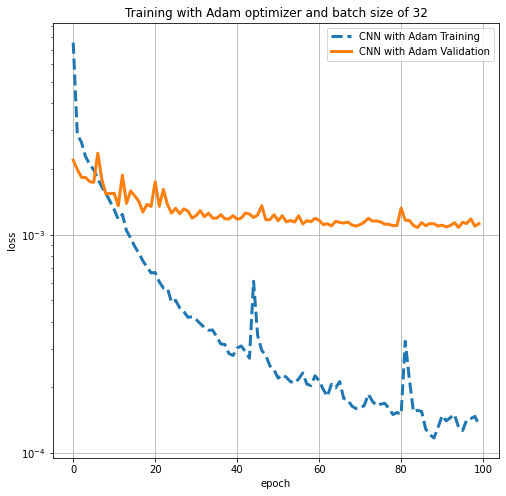

In [144]:
# Plot training and validation loss
plt.figure(figsize=(8,8))
plot_loss(baseline_adam_fit,"CNN with Adam ")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training with Adam optimizer and batch size of 32")
plt.show()

Given that the validation loss is higher than training loss throughout most of the graph, we can assume that the model is overfitting the training set with the Adam optimizer. 

###### Predicting with CNN model trained with Adam optimizer

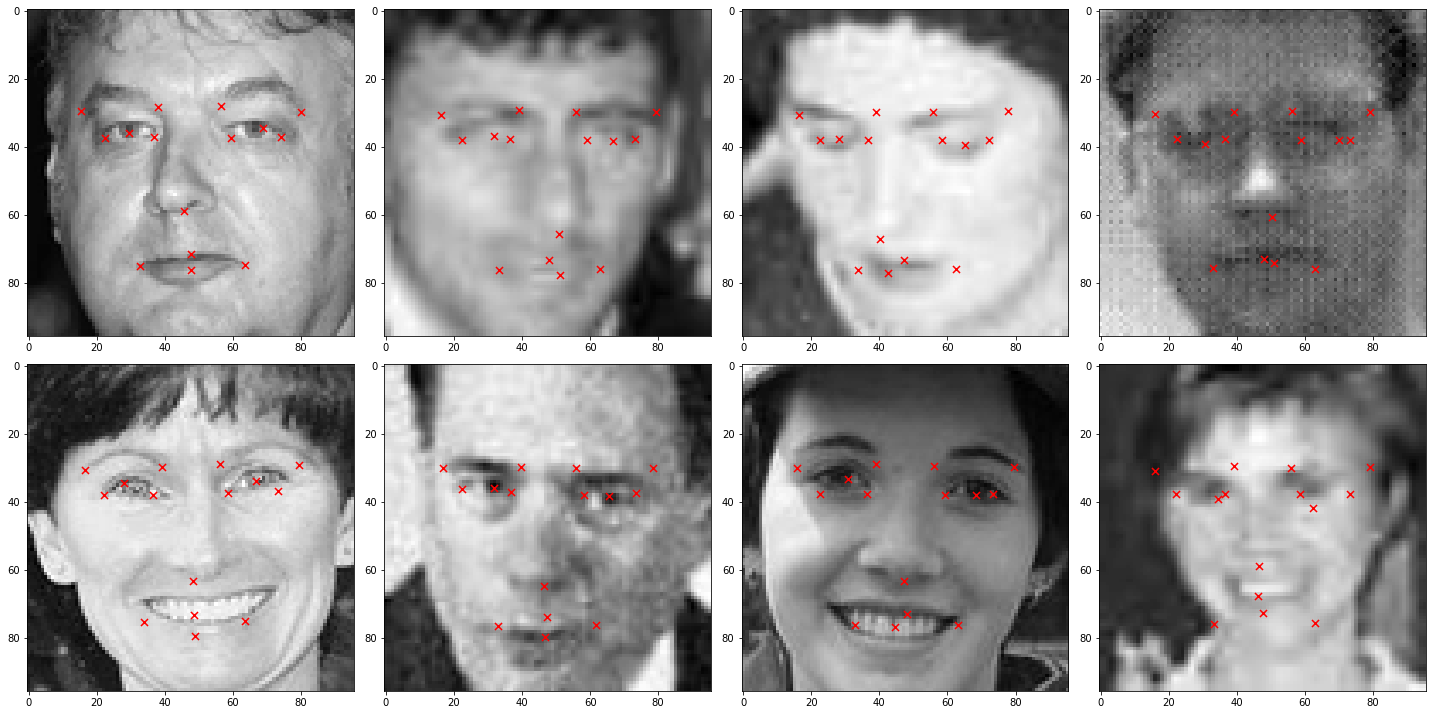

In [145]:
testing_images, _ = loadData(test=True)
baseline_adam_pred = baseline_adam.predict(testing_images)

plot_sample_images(testing_images, baseline_adam_pred, 2, 4)

Many of the same issues with previous models can be seen here with difficulties in finding mouth corner keypoints and inaccuracies in more pixelated images. Again, there was not a stark difference visually between this model and previous models outside of some of the mouth keypoints.

### Creating Submission file for Kaggle

In [146]:
lookid_list = list(lookup_df['FeatureName'])
imageID = list(lookup_df['ImageId']-1)
pre_list = list(baseline_adam_pred)


In [147]:
rowid = lookup_df['RowId']
rowid=list(rowid)

In [148]:
feature = []
for f in list(lookup_df['FeatureName']):
    feature.append(lookid_list.index(f))

In [149]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [150]:
preded = np.array(preded, dtype = 'float') *48 + 48

In [151]:
preded

array([65.63156176, 36.5441587 , 29.73861122, ..., 65.23793077,
       47.788895  , 77.44839191])

In [152]:
rowid = pd.Series(rowid,name = 'RowId')

In [153]:
loc = pd.Series(preded,name = 'Location')

In [154]:
submission = pd.concat([rowid,loc],axis = 1)

In [155]:
submission.to_csv('submission/face_key_detection_submission_final.csv',index = False)